# 多尺度目标检测

在[“锚框”](anchor.md)一节中，我们在实验中以输入图像的每个像素为中心生成多个锚框。这些锚框是对输入图像不同区域的采样。然而，如果以图像每个像素为中心都生成锚框，很容易生成过多锚框而造成计算量过大。举个例子，假设输入图像的高和宽分别为 561 和 728 像素，如果以每个像素为中心生成 5 个不同形状的锚框，那么一张图像上则需要标注并预测两百多万个锚框（$561 \times 728 \times 5$）。

减少锚框个数并不难。一个简单的方法是在输入图像中均匀采样一小部分像素，并以采样的像素为中心生成锚框。此外，在不同尺度下，我们可以生成不同数量和不同大小的锚框。值得注意的是，较小目标比较大目标在图像上出现位置的可能性更多。举个简单的例子：形状为 $1 \times 1$、$1 \times 2$ 和 $2 \times 2$ 的目标在形状为 $2 \times 2$ 的图像上可能出现的位置分别有 4、2 和 1 种。因此，当使用较小锚框来检测较小目标时，我们可以采样较多的区域；而当使用较大锚框来检测较大目标时，我们可以采样较少的区域。

为了演示如何多尺度生成锚框，我们先读取一张图像。它的高和宽分别为 561 和 728 像素。

In [1]:
import sys
sys.path.insert(0,'../')

In [2]:
import gluonbook as gb
from mxnet import contrib,image,nd

img = image.imread('../img/catdog.jpg')
h,w = img.shape[0:2]
h,w

(561, 728)

我们在[“二维卷积层”](../chapter_convolutional-neural-networks/conv-layer.md)一节中将卷积神经网络的二维数组输出称为特征图。
我们可以通过定义特征图的形状来确定任一图像上均匀采样的锚框中心。

下面定义`display_anchors`函数。我们在特征图`fmap`上以每个单元（像素）为中心生成锚框`anchors`。由于锚框`anchors`中 $x$ 和 $y$ 轴的坐标值分别已除以特征图`fmap`的宽和高，这些值域在 0 和 1 之间的值表达了锚框在特征图中的相对位置。由于锚框`anchors`的中心遍布特征图`fmap`上的所有单元，`anchors`的中心在任一图像的空间相对位置一定是均匀分布的。具体来说，当特征图的宽和高分别设为`fmap_w`和`fmap_h`时，该函数将在任一图像上均匀采样`fmap_h`行`fmap_w`列个像素，并分别以它们为中心生成大小为`s`（假设列表`s`长度为 1）的不同宽高比（`ratios`）的锚框。

In [3]:
#前两位不影响输出
def display_anchors(fmap_w,fmap_h,s):
    fmap = nd.zeros((1,10,fmap_w,fmap_h))
    anchors= contrib.nd.MultiBoxPrior(fmap,sizes=s,ratios=[1,2,0.5])
    bbox_scale = nd.array((w,h,w,h))
    gb.show_bboxes(gb.plt.imshow(img.asnumpy()).axes,anchors[0]*bbox_scale)

 * 我们先关注小目标的检测，为了在显示是时更加容易分辨，这里令不同中心的锚框不重合；设置锚框大小为0.15，特征图高和宽为4

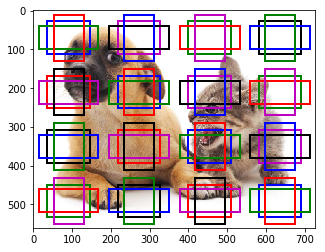

In [4]:
display_anchors(4,4,s=[0.15])

* 下面将宽和高减半

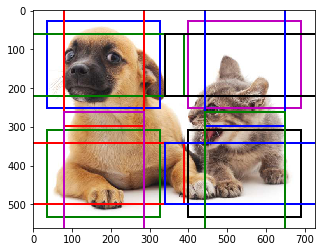

In [5]:
display_anchors(2,2,s=[0.4])

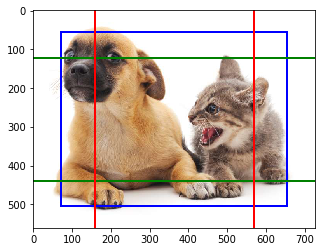

In [7]:
display_anchors(1,1,s=[0.8])


## 小结

* 我们可以在多个尺度下生成不同数量不同大小的锚框，从而在多个尺度下检测不同大小的目标。
* 特征图的形状能确定任一图像上均匀采样的锚框中心。
* 我们用输入图像在某个感受野区域内的信息来预测输入图像上与该区域相近的锚框的类别和偏移量。


* 给定一张输入图像，设特征图变量的形状为 $1 \times c_i \times h \times w$，其中 $c_i, h, w$ 分别为特征图的个数、高和宽。你能想到哪些将该变量变换为锚框的类别和偏移量的方法？输出的形状分别是什么？

加入一个1x1卷积层，输出为 (1,类别总数+4，h，w)